# ECON323 Final Project: Correlation between number of COVID-19 severity and travelling

## Background

As vaccines become more effective and new booster shots become available, it seems like the world is transitioning to a “new normal” during the pandemic. Many countries indeed opened up borders for international travelling and non-citizen entry. This project seeks to evaluate whether there is a correlation between the number of COVID-19 cases within each country with the number of tourists into each country from January 2021 to September 2021. 

## Hypothesis

I hypothesize that as the number of COVID-19 cases decreases, the number of tourists increases for each country. Therefore, as I expect the number of COVID-19 cases to decrease from January to September, I expect to see a negative correlation and the number of tourists to increase during the same time period.

## Import

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)
import os
from urllib.request import urlopen
import json
from IPython.display import HTML

import seaborn as sns

## Dataset

I will use data from [Johns Hopkins University Center for Systems
Science and
Engineering](https://github.com/CSSEGISandData/COVID-19) to extract number of confirmed cases, focusing on a total of 8 countries. I will also be extracting information from governmental statistics on the number of visiters per country.

#### COVID-19 Cases

In [3]:
confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,157858,157858,157858,157648,157660,157665,157725,157734,157745,157787
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,203215,203524,203787,203925,204301,204627,204928,205224,205549,205777
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,212434,212652,212848,213058,213288,213533,213745,214044,214330,214592
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,19440,19440,19440,19440,20136,20136,20549,20549,20549,20549
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,65371,65397,65404,65404,65431,65565,65648,65760,65868,65938


In [4]:
confirmed = confirmed_raw.transpose().drop(labels=["Country/Region", "Province/State", "Lat", "Long"])
confirmed = confirmed.reset_index().rename(columns={"index":"Date"})
confirmed["Date"] = pd.to_datetime(confirmed["Date"])
country = confirmed_raw["Country/Region"]
c1 = ["Date"]
c1[1:] = country
confirmed.columns = pd.Series(c1)
date_2021 = (confirmed['Date'] >= '2020-6-1') & (confirmed['Date'] < '2021-6-1')
filtered = confirmed.loc[date_2021].reset_index(drop=True)
filtered

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,2020-06-01,15836,1143,9513,765,86,26,17415,9492,107,...,257579,825,3702,0,1662,328,449,354,1089,203
1,2020-06-02,16578,1164,9626,844,86,26,18319,10009,107,...,259046,826,3760,0,1819,328,451,399,1089,206
2,2020-06-03,17353,1184,9733,851,86,26,19268,10524,107,...,260388,828,3843,0,1952,328,457,419,1089,222
3,2020-06-04,17977,1197,9831,852,86,26,20197,11221,107,...,261622,832,3939,0,2087,328,464,453,1089,237
4,2020-06-05,19055,1212,9935,852,86,26,21037,11817,107,...,262727,834,4007,0,2145,328,464,469,1089,265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2021-05-27,68366,132264,127926,13682,33607,1258,3663215,222409,124,...,4473677,280372,99344,4,228828,6356,306795,6696,93947,38854
361,2021-05-28,69130,132285,128198,13693,33944,1259,3702422,222513,124,...,4477705,282198,99580,4,230147,6396,307569,6723,94430,38918
362,2021-05-29,70111,132297,128456,13693,34180,1259,3732263,222555,124,...,4480945,288172,99844,4,231443,6908,307838,6731,94751,38933
363,2021-05-30,70761,132309,128725,13693,34366,1259,3753609,222636,124,...,4484056,291488,100124,4,232800,7107,308048,6737,95050,38944


In [5]:
Canada = filtered[['Canada']].sum(axis=1)
UK = filtered[['United Kingdom']].sum(axis=1)
US = filtered[['US']].sum(axis=1)
Brazil = filtered[['Brazil']].sum(axis=1)
Mexico = filtered[['Mexico']].sum(axis=1)
Germany = filtered[['Germany']].sum(axis=1)
Japan = filtered[['Japan']].sum(axis=1)
Spain = filtered[['Spain']].sum(axis=1)
selected_countries = pd.DataFrame({'Date': filtered['Date'], 'Canada': Canada, 'United Kingdom': UK, 'US': US, 
                                   'Brazil': Brazil, 'Mexico': Mexico, 'Germany': Germany, 'Japan': Japan, 'Spain': Spain})
selected_countries

,Date,Canada,United Kingdom,US,Brazil,Mexico,Germany,Japan,Spain
0,2020-06-01,93330.0,258983.0,1816108.0,526447.0,93435.0,183594.0,16778.0,239638.0
1,2020-06-02,93991.0,260453.0,1837391.0,555383.0,97326.0,183879.0,16829.0,239932.0
2,2020-06-03,94658.0,261802.0,1857162.0,584016.0,101238.0,184121.0,16858.0,240326.0
3,2020-06-04,95283.0,263040.0,1878885.0,614941.0,105680.0,184472.0,16902.0,240660.0
4,2020-06-05,95949.0,264150.0,1903886.0,645771.0,110026.0,184924.0,16949.0,240978.0
...,...,...,...,...,...,...,...,...,...
360,2021-05-27,1379674.0,4489552.0,33297441.0,16342162.0,2405772.0,3673990.0,734526.0,3663176.0
361,2021-05-28,1382769.0,4493582.0,33319364.0,16391930.0,2408778.0,3680159.0,738229.0,3668658.0
362,2021-05-29,1384928.0,4496823.0,33331982.0,16471600.0,2411503.0,3684672.0,741822.0,3668658.0
363,2021-05-30,1386871.0,4499937.0,33338954.0,16515120.0,2412810.0,3687715.0,744696.0,3668658.0


In [8]:
June20 = selected_countries.loc[(selected_countries['Date'] >= '2020-6-1') & (selected_countries['Date'] < '2020-7-1')].mean()
July20 = selected_countries.loc[(selected_countries['Date'] >= '2020-7-1') & (selected_countries['Date'] < '2020-8-1')].mean()
August20 = selected_countries.loc[(selected_countries['Date'] >= '2020-8-1') & (selected_countries['Date'] < '2020-9-1')].mean()
September20 = selected_countries.loc[(selected_countries['Date'] >= '2020-9-1') & (selected_countries['Date'] < '2020-10-1')].mean()
October20 = selected_countries.loc[(selected_countries['Date'] >= '2020-10-1') & (selected_countries['Date'] < '2020-11-1')].mean()
November20 = selected_countries.loc[(selected_countries['Date'] >= '2020-11-1') & (selected_countries['Date'] < '2020-12-1')].mean()
December20 = selected_countries.loc[(selected_countries['Date'] >= '2020-12-1') & (selected_countries['Date'] < '2021-1-1')].mean()
January21 = selected_countries.loc[(selected_countries['Date'] >= '2021-1-1') & (selected_countries['Date'] < '2021-2-1')].mean()
Febuary21 = selected_countries.loc[(selected_countries['Date'] >= '2021-2-1') & (selected_countries['Date'] < '2021-3-1')].mean()
March21 = selected_countries.loc[(selected_countries['Date'] >= '2021-3-1') & (selected_countries['Date'] < '2021-4-1')].mean()
April21 = selected_countries.loc[(selected_countries['Date'] >= '2021-4-1') & (selected_countries['Date'] < '2021-5-1')].mean()
May21 = selected_countries.loc[(selected_countries['Date'] >= '2021-5-1') & (selected_countries['Date'] < '2021-6-1')].mean()
sc_month = pd.DataFrame({'June/20': June20, 'July/20': July20, 'August/20': August20, 'September/20': September20,
                         'October/20': October20, 'November/20': November20, 'December/20': December20, 'January/21': January21, 
                         'Febuary/21': Febuary21, 'March/21': March21, 'April/21': April21, 'May/21': May21})
pd.set_option('display.float_format', lambda x: '%.1f' % x)
sc_month = sc_month.transpose().reset_index().rename(columns={"index":"Date"})
sc_month


,Date,Canada,United Kingdom,US,Brazil,Mexico,Germany,Japan,Spain
0,June/20,100509.3,273778.6,2164115.5,938707.4,156414.7,189025.4,17512.1,244373.1
1,July/20,111620.6,294206.5,3594171.6,2020705.3,326056.1,202099.3,24827.0,262396.5
2,August/20,124222.8,320443.8,5367395.7,3319480.5,519613.7,226604.3,54898.7,359969.1
3,September/20,143528.3,385483.5,6639974.8,4401998.7,676971.7,267450.7,76564.1,610542.0
4,October/20,198838.7,709760.3,8111371.2,5193275.5,841218.4,375904.6,92118.2,951441.7
5,November/20,305902.8,1361032.5,11337625.4,5894580.7,1011404.8,818812.0,121613.8,1464426.1
6,December/20,487311.9,1979527.9,17080976.2,7040314.1,1276998.6,1422912.3,189580.2,1776379.3
7,January/21,700652.5,3296141.8,23647506.5,8425391.7,1633946.2,2017913.7,319813.4,2296154.4
8,Febuary/21,831395.4,4043274.4,27717635.8,9873432.1,1988500.4,2345023.4,415838.9,3056001.4
9,March/21,924612.7,4281353.7,29637798.2,11647085.9,2170826.5,2620795.2,451395.6,3202600.9


#### Number of International Travellers

In [9]:
# Canada data from: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2410004101&pickMembers%5B0%5D=1.1&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=2021&cubeTimeFrame.endMonth=09&cubeTimeFrame.endYear=2021&referencePeriods=20210101%2C20210901
visit_c = [858709, 944343, 1029863, 1010470, 1039232, 961840, 1046105, 1047375, 875292, 1002245, 999014, 1027393]
# Uk data from: https://www.gov.uk/government/statistics/statistics-relating-to-passenger-arrivals-since-the-covid-19-outbreak-november-2021/statistics-relating-to-passenger-arrivals-in-the-united-kingdom-since-the-covid-19-outbreak-november-2021
visit_uk = [194900, 1260400, 3106500, 2757700, 1741100, 690600, 895800, 631500, 319200, 386600, 447300, 527800]
# US data from: https://tradingeconomics.com/united-states/tourist-arrivals
visit_us = [320000, 515000, 720000, 610000, 735000, 900000, 1125000, 1040000, 700000, 1075000, 1380000, 1775000]
# Brazil data from: https://www.statista.com/statistics/1105022/international-air-passenger-traffic-monthly-brazil/
visit_b = [67540, 87130, 120060, 144610, 189600, 246270, 416390, 382160, 195360, 187270, 162280, 194690]
# Mexico data from: https://tradingeconomics.com/mexico/tourist-arrivals
visit_m = [286110, 530960, 535640, 606088, 828015, 984903, 1481639, 822459, 698304, 1176773, 1184735, 1509900]
# Germany data from: https://tradingeconomics.com/germany/tourist-arrivals
visit_g = [616699, 1850639, 1791281, 1351462, 776459, 224096, 172016, 169186, 182055, 231068, 219790, 291709]
# Japan data from: https://tradingeconomics.com/japan/tourist-arrivals
visit_j = [2600, 3800, 8700, 13700, 27400, 56700, 58700, 46500, 7400, 12300, 10900, 10000]
# Spain data from: https://tradingeconomics.com/spain/tourist-arrivals
visit_s = [204272, 2464779, 2440978, 1138868, 1020773, 456814, 648989, 434362, 284311, 490088, 630647, 1363624]

dates = ['June/20', 'July/20', 'August/20', 'September/20', 'October/20', 'November/20', 'December/20',
        'January/21', 'Febuary/21', 'March/21', 'April/21', 'May/21']
visiters = pd.DataFrame({'Date': dates, 'Canada': visit_c, 'United Kingdom': visit_uk, 'US': visit_us, 
                         'Brazil': visit_b, 'Mexico': visit_m, 'Germany': visit_g, 'Japan': visit_j, 'Spain': visit_s})
visiters


,Date,Canada,United Kingdom,US,Brazil,Mexico,Germany,Japan,Spain
0,June/20,858709,194900,320000,67540,286110,616699,2600,204272
1,July/20,944343,1260400,515000,87130,530960,1850639,3800,2464779
2,August/20,1029863,3106500,720000,120060,535640,1791281,8700,2440978
3,September/20,1010470,2757700,610000,144610,606088,1351462,13700,1138868
4,October/20,1039232,1741100,735000,189600,828015,776459,27400,1020773
5,November/20,961840,690600,900000,246270,984903,224096,56700,456814
6,December/20,1046105,895800,1125000,416390,1481639,172016,58700,648989
7,January/21,1047375,631500,1040000,382160,822459,169186,46500,434362
8,Febuary/21,875292,319200,700000,195360,698304,182055,7400,284311
9,March/21,1002245,386600,1075000,187270,1176773,231068,12300,490088


## Analysis

#### 1) Examining COVID-19 cases in the selected countries

<AxesSubplot:xlabel='Date'>

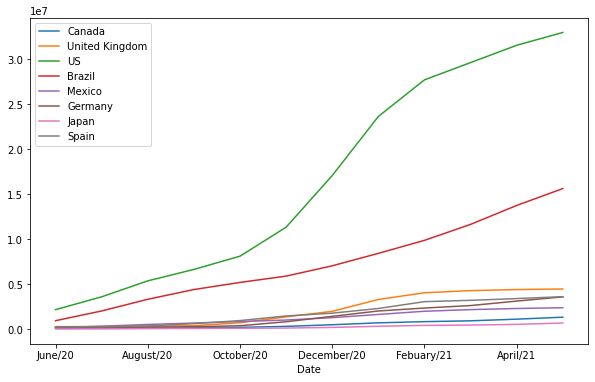

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sc_month.plot(x='Date', y=['Canada', 'United Kingdom', 'US', 'Brazil', 'Mexico', 'Germany', 'Japan', 'Spain'], ax=ax)

This plot demonstrates what we anticipated with COVID-19 cases. Over the time period from June 2020 to May 2021, it is apparent that **COVID-19 cases across all countries increased**, with US increasing significantly more than other countries. Thus, let's now examine the number of tourists to see whether it also follows our anticipated overall trend.

#### 2) Examining tourists in the selected countries

<AxesSubplot:xlabel='Date'>

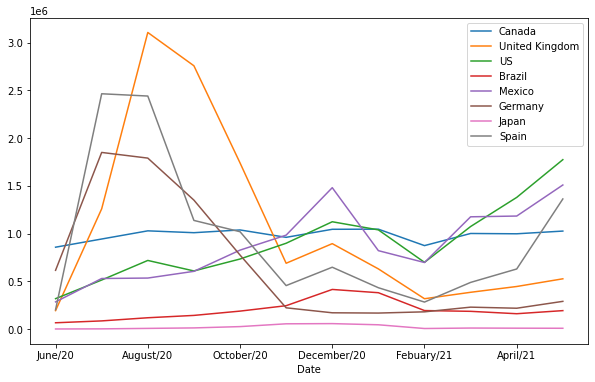

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
visiters.plot(x='Date', y=['Canada', 'United Kingdom', 'US', 'Brazil', 'Mexico', 'Germany', 'Japan', 'Spain'], ax=ax)

From this visualization of the number of tourists per country per month, we can see that **each country follows a very different trend**. This is **very different from what we anticipated** since for all countries, we see a increasing number of cases over the same time period while the number of tourists in each country did not necessarily decrease. For example, Canada's data follows a relatively horizontal flat trend and does not vary a lot. On the contrary, we can see that United Kingdom's number of tourists changed drastically over the year from June 2020 to May 2021 and it had both an increase and decrease. Therefore, we cannot draw significance just by analyzing the number of COVID-19 cases and the number of tourists alone as we have to further analyze this data side by side in each country to determine whether there is a correlation between COVID-19 severity and travelling.

#### 3) Examining relationship between COVID-19 cases and tourists per country

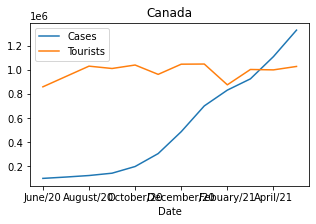

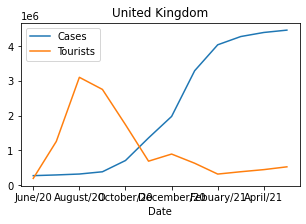

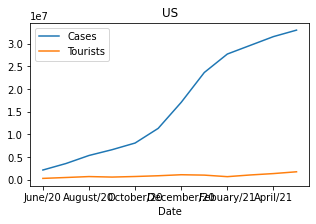

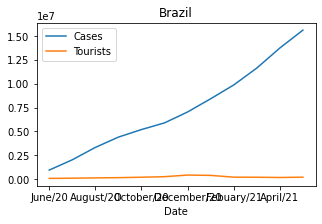

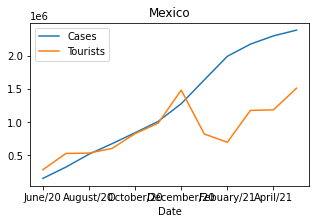

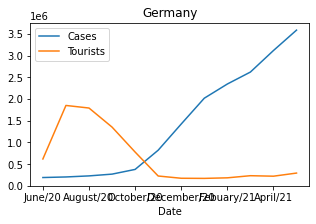

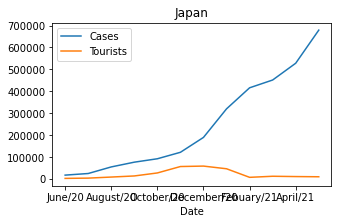

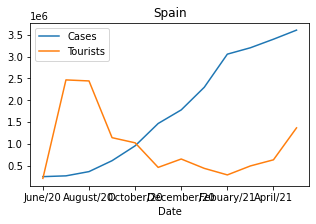

In [12]:
def extract_country(c):
    country = pd.concat([visiters['Date'], sc_month[c]], axis=1)
    country = country.rename(columns={country.columns[1]:"Cases"})
    country = pd.concat([country, visiters[c]], axis=1)
    country = country.rename(columns={country.columns[2]:"Tourists"})
    return country

for country in visiters.columns[1:]:
    fig, ax = plt.subplots(figsize=(5,3))
    country_plot = extract_country(country)
    country_plot.plot(x='Date', y=['Cases', 'Tourists'], ax=ax)
    ax.set_title(f"{country}")

By plotting number of COVID-19 cases and the number of tourists side by side for each country, the specific relationship became more apparent. Specifically, we can see that the countries generally **fall into 3 trends**. For Canada, US, Brazil, and Japan, the number of tourists stay relatively flat despite the increase in confirmed cases. For United Kingdom, Germany, and Spain, the number of tourists somewhat decreases over time while number of confirmed cases increase. Lastly, Mexico is special since its number of tourists increase with the increase in confirmed cases which is super rare. 

**Let's now try creating scatterplots and fitting a best-fit line for each country.**

Canada: 
           Cases  Tourists
Cases       1.0       0.2
Tourists    0.2       1.0
United Kingdom: 
           Cases  Tourists
Cases       1.0      -0.6
Tourists   -0.6       1.0
US: 
           Cases  Tourists
Cases       1.0       0.8
Tourists    0.8       1.0
Brazil: 
           Cases  Tourists
Cases       1.0       0.3
Tourists    0.3       1.0
Mexico: 
           Cases  Tourists
Cases       1.0       0.7
Tourists    0.7       1.0
Germany: 
           Cases  Tourists
Cases       1.0      -0.7
Tourists   -0.7       1.0
Japan: 
           Cases  Tourists
Cases       1.0      -0.1
Tourists   -0.1       1.0
Spain: 
           Cases  Tourists
Cases       1.0      -0.4
Tourists   -0.4       1.0


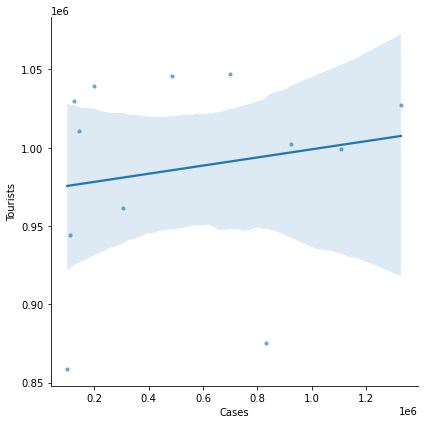

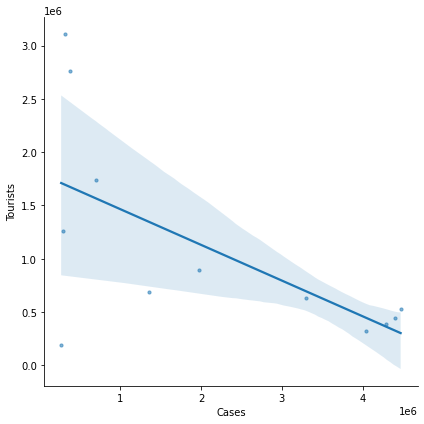

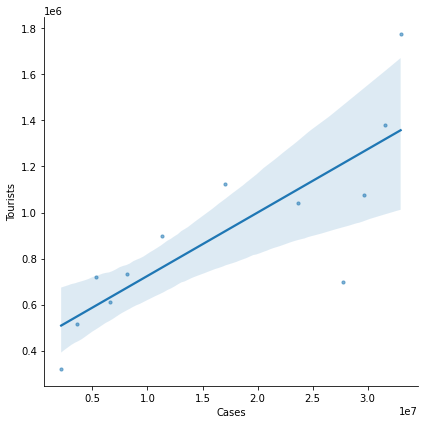

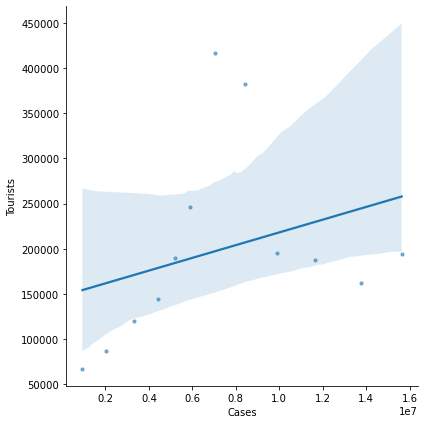

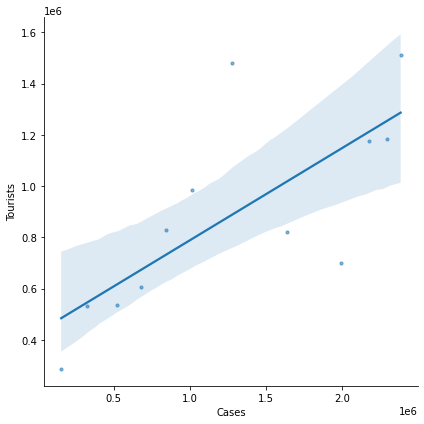

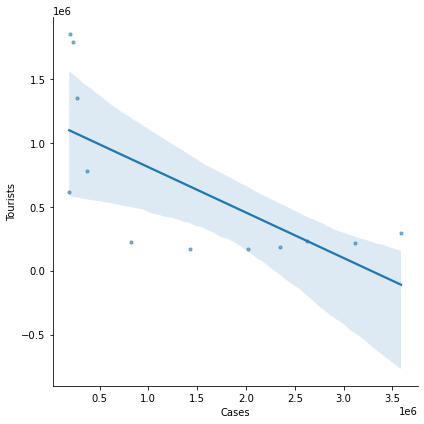

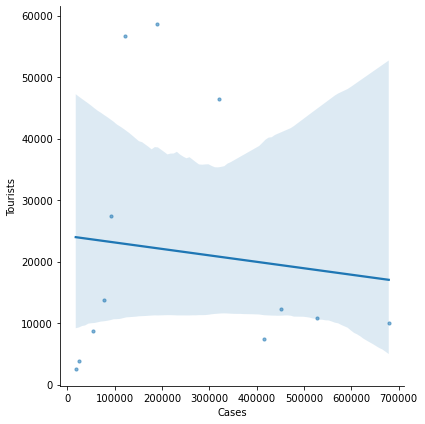

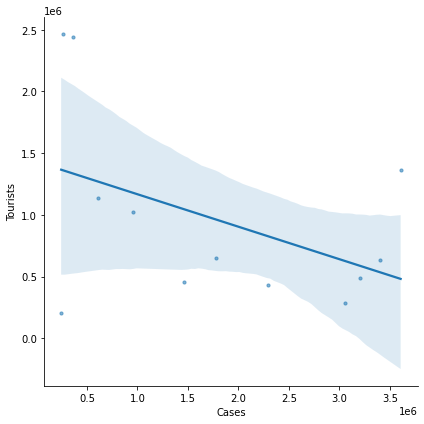

In [25]:
for country in visiters.columns[1:]:
    country_plot = extract_country(country)
    sns.lmplot(data=country_plot, x="Cases", y="Tourists", height=6, scatter_kws=dict(s=10, alpha=0.55));
    print(f"{country}: \n {country_plot.corr(method='pearson')}")

First, we can identify that there is a weak correlation between COVID-19 cases and the number of tourists for Canada, Brazil, Japan, and Spain (with r<0.5). For the other 5 countries, there is a relatively stronger correlation. The correlation charts and the regression graphs also validates the trends we have seen previously, where United Kingdom, Germany,and Spain follows the anticipated strong negative relationship between the number of COVID-19 cases and the number of tourists. 

From these analysis, I also identified an interesting perspective. Countries in the Americas, including Canada, US, Mexico, and Brazil, all demonstrated an unanticipated positive relationship between the number of COVID-19 cases and the number of tourists for each of these countries. However, countries in Europe demonstrates an opposite trend.

**Let's now try and combine data from all of the selected countries to see whether we can predict future amount of tourists.**

#### 4) Linear regression for tourists from all selected countries

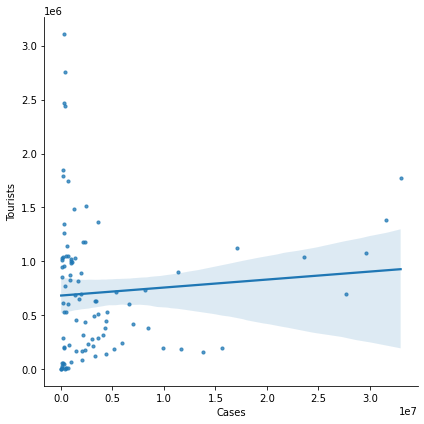

In [45]:
def extract_country_nodate(c):
    country = pd.concat([sc_month[c]], axis=1)
    country = country.rename(columns={country.columns[0]:"Cases"})
    country = pd.concat([country, visiters[c]], axis=1)
    country = country.rename(columns={country.columns[1]:"Tourists"})
    return country

can = extract_country_nodate("Canada")
all_sc_together = can

for country in visiters.columns[2:]:
    country_data = extract_country_nodate(country)
    all_sc_together = all_sc_together.append(country_data, ignore_index=True)

sns.lmplot(data=all_sc_together, x="Cases", y="Tourists", height=6, scatter_kws=dict(s=10, alpha=0.75));

I first tried to plot one graph using data from all selected countries. But as we can see, it resulted in a very random plot with no correlation and with all the data clustered at the left. Therefore, using the insights from above that countries' results are divided by continents, let's try now to separate those countries and plot individually. Since Japan is not in either Americas nor Europe, I decided to exclude Japan in this specific analysis.

          Cases  Tourists
Cases       1.0       0.3
Tourists    0.3       1.0


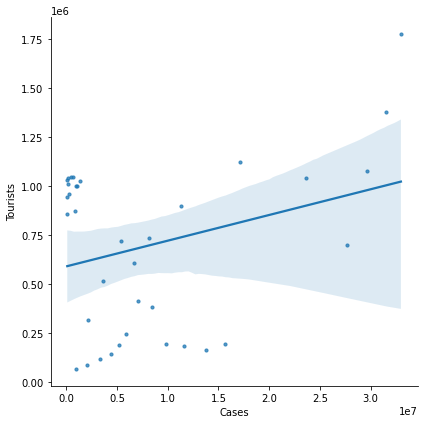

In [50]:
can = extract_country_nodate("Canada")
all_sc_together_americas = can
for country in visiters.columns[3:5]:
    country_data = extract_country_nodate(country)
    all_sc_together_americas = all_sc_together_americas.append(country_data, ignore_index=True)
sns.lmplot(data=all_sc_together_americas, x="Cases", y="Tourists", height=6, scatter_kws=dict(s=10, alpha=0.75));
print(f"{all_sc_together_americas.corr(method='pearson')}")

          Cases  Tourists
Cases       1.0      -0.1
Tourists   -0.1       1.0


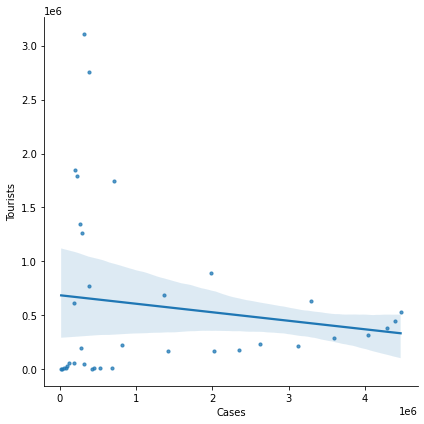

In [51]:
uk = extract_country_nodate("United Kingdom")
all_sc_together_europe = uk
for country in visiters.columns[6:8]:
    country_data = extract_country_nodate(country)
    all_sc_together_europe = all_sc_together_europe.append(country_data, ignore_index=True)
sns.lmplot(data=all_sc_together_europe, x="Cases", y="Tourists", height=6, scatter_kws=dict(s=10, alpha=0.75));
print(f"{all_sc_together_europe.corr(method='pearson')}")

From plotting the relationship between COVID-19 cases and the number of tourists by grouping continents together, we can see that indeed the hypothesis that this relationship vary by continent instead of by country fails. The two correlations are 0.3 for the Americas and -0.1 for Europe. Although their general positive or negative trend are the same, it demonstrates a very low correlation. Therefore, the relationship between COVID-19 confirmed cases and the number of tourists does not vary by continent and their similarity in general trends is not useful in categorizing the relationship and **prediction for the number of tourists based on the number of COVID-19 cases will not be feasible nor helpful.**

## Conclusion

This study tries to evaluate the relationship between the number of COVID-19 confirmed cases and the number of tourists for countries around the world, and predict the number of tourists based on this relationship if feasible. However, from our study, we see a **weak correlation between COVID-19 confrimed cases and the number of tourists in general as each country follows a different trend**.

Although there are generally 3 trends, one flat, one positive, and one negative, we latter identified that this categorization of trend can not be used to categorize the relationship between COVID-19 confirmed cases and the number of tourists since the correlation of the calculated relationships are lower than expected (r<0.5). Indeed, the **relationship between COVID-19 confirmed cases and the number of tourists vary on a case by case scenario for each country** and no grouping can be conducted to construct further analysis on this relationship such as prediction. Prediction can only be done on each country separately and I genuinely believe that this calculation will no longer be helpful to extract further insights.

Since I only constructed this analysis around the sole relationship between the number COVID-19 confirmed cases and the number of tourists, I believe that my results lead to further considerations. First, the number of tourists during the pandemic will also be impacted by factors such as policy changes, governmental regulations, presence of vaccines, and cultural believe differences. My study hints how these factors might have a bigger impact on the number of tourists under the current pandemic instead of the number of COVID-19 confirmed cases in each country. Nonetheless, this will be left for future research. 

Thus **my study rejects my initial hypothesis** and lead to the following conclusion: **the number of tourists in each country does not directly depend on COVID-19 severity and the number of COVID-19 confirmed cases in each country**. The number of tourists during pandemic will likely be directly impacted by other factors mentioned above.

## Limitations

#### Insufficient data from other countries

During my research, it was very hard to find tourists arrival data from countries such as China, France, Argentina, etc. My only remaining option is to conduct this study with a smaller subset of countries. This limits my study as all the other countries might have significantly different conclusions and relationships between the number of COVID-19 cases and the number of tourists which I could not identify. 

#### Number of tourists might be understated

When I was extracting data for this study, I found out how tourists data for some of the countries are sometimes limited to air arrival or unclear. This might have a significant impact on my study as the number of tourists might be understated. The number of tourists arriving at the selected countries have the possibility to not account for those who arrived through driving, ships, etc. 

## Further Research

Based on limitations I mentioned above, I suggest the following two areas for further research:
1) To gather information from more countries regarding the number of tourists per month from 2020 to 2021
2) To analyze the relationship between the number of tourists per month during COVID-19 with other factors